In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from scipy import constants
from scipy.linalg import lstsq
from matplotlib.animation import FuncAnimation
from matplotlib.animation import writers
import matplotlib.gridspec as gridspec
from Simbo import generate_levels, getrand, setzero, exchange, recdist, accum, calc_Eav, calc_Bolt_ent
from Simbo import calc_av_ent, calc_prob_temp, find_max, find_skips, plot_prob_temp, store_data, store_eq_data
from Simbo import print_w_sw, get_w_sw

k_B = constants.value(u'Boltzmann constant')
h = constants.value(u'Planck constant')
c = constants.value(u'speed of light in vacuum')

<IPython.core.display.Javascript object>


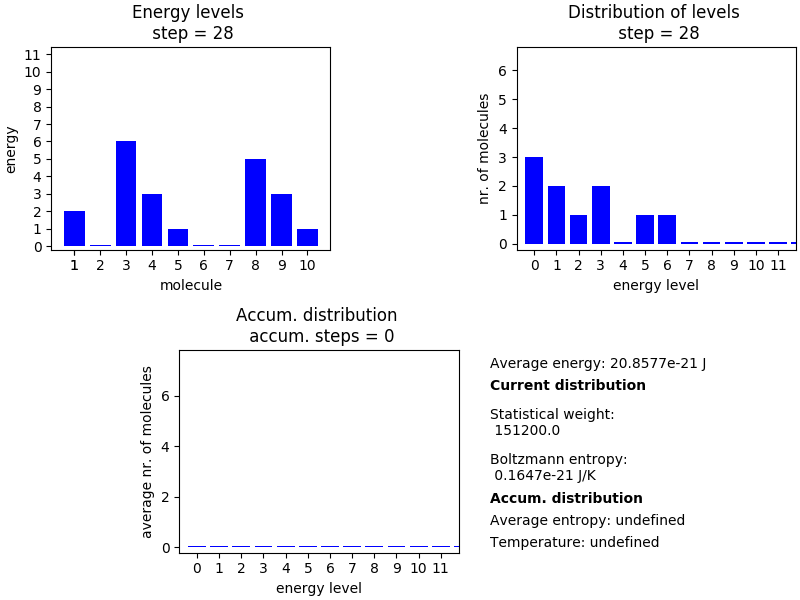

6.0


In [4]:
#run short simulation
%matplotlib notebook

nu = 500e2
nop = 10 ##user input
en = 2 ##user input

#initialize
istep = 0
nstot = 40*nop
nseqv = 20*nop

#automatic generation of levels
levels = generate_levels(en, nop)

#manual input
#levels = [12, 0, 0, 0, 0, 0, 0, 0, 0, 0]

maxlev, idist, dist_sum, nstep = setzero(levels)
      
#prepare graphs
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
gs = fig.add_gridspec(2, 4)
gs.update(wspace=0.5)
ax1 = fig.add_subplot(gs[0, :2], )
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 1:3])
all_levels = []
all_distr = []
all_dist_sum = []
all_uav = []
all_wbolt = []
all_sw = []
all_sa = []
all_temp = []

zero_array = []

for i in range(int(sum(levels))+1):
    zero_array.append(0.05)

#run
while istep < nstot:
    
    bef = istep
    
    #get random molecules
    ifrom, ito = getrand(nop)
    
    #exchange energy
    levels, istep = exchange(ifrom, ito, nop, levels, istep)
    
    if istep > bef: #exchange not possible sometimes (level[ifrom] = 0)
        
        #calculate distribution over energy levels
        distr, all_levels, all_distr = recdist(nop, levels, maxlev, all_levels, all_distr)
    
        #calculate accumulated distribution
        if istep > nseqv: #check if equilibrated
            
            idist, dist_sum, all_dist_sum, nstep = accum(nop, maxlev, idist, distr, dist_sum, nstep, all_dist_sum)
            all_uav, all_wbolt, all_sw, all_sa, all_temp = store_data(all_uav, maxlev, nop, distr, all_wbolt, 
                                                                      all_sw, all_sa, dist_sum, all_temp)
            nstep+=1
            
        else:
            
            all_dist_sum, all_uav, all_wbolt, all_sw, all_sa, all_temp = store_eq_data(zero_array, all_dist_sum, 
                                                    all_uav, maxlev, distr, nop, all_wbolt, all_sw, all_sa, all_temp)
            
#animate plot data

#find maxima of stored data
max_level, max_dist, max_distr_sum = find_max(all_levels, all_distr, all_dist_sum)
print(max_dist)

def animation_frame(i):
    plt.rcParams.update({'font.size': 10})
    ax1.cla()

    labels1 = np.arange(1, nop+1, 1)
    trimmed_dist1 = all_levels[i]

    xrange_ = np.arange(0, nop+1, find_skips(nop+1))
    xticks = xrange_[1:]
    xticks = [1, *xticks]
    ax1.set_xticks(xticks)
    ax1.set_yticks(np.arange(0, max_level+1, find_skips(max_level)))
    ax1.set_xlabel('molecule')
    ax1.set_ylabel('energy')
    ax1.set_ylim(-0.2, max_level+1-0.6)
    ax1.bar(x=labels1, height=trimmed_dist1, color='b')
    ax1.set_title(f'Energy levels \n step = {i}')

    ax2.cla()

    labels2 = np.arange(0, maxlev, 1)
    trimmed_dist2 = all_distr[i]
    ax2.set_xticks(np.arange(0, max_level+1, find_skips(max_level)))
    ax2.set_yticks(np.arange(0, max_dist+1, find_skips(max_dist)))
    ax2.set_ylabel('nr. of molecules')
    ax2.set_xlabel('energy level')
    ax2.set_ylim(-0.2, max_dist+1-0.2)
    ax2.set_xlim(-0.8, max_level+1-0.2)
    ax2.bar(x=labels2, height=trimmed_dist2, color='b')
    ax2.set_title(f'Distribution of levels \n step = {i}')

    ax3.cla()

    labels3 = np.arange(0, maxlev, 1)
    trimmed_dist3 = all_dist_sum[i]
    ax3.set_xticks(np.arange(0, max_level+1, find_skips(max_level)))
    ax2.set_yticks(np.arange(0, max_distr_sum, find_skips(max_distr_sum)))
    ax3.set_ylabel('average nr. of molecules')
    ax3.set_xlabel('energy level')
    ax3.set_ylim(-0.2, max_distr_sum+1-0.2)
    ax3.set_xlim(-0.8, max_level+1-0.2)
    ax3.bar(x=labels3, height=trimmed_dist3, color='b')
    
    xv = (max_level+1)*1.1
    yv = max_distr_sum+1
        
    ax3.text(xv, yv*(8/9), 'Average energy: %.4fe-21 J'%((all_uav[i])*h*c*nu*1e21))
    ax3.text(xv, yv*(7/9), 'Current distribution', fontweight='bold')
    ax3.text(xv, yv*(5/9), 'Statistical weight: \n %.1f' %(all_wbolt[i]))
    ax3.text(xv, yv*(3/9), 'Boltzmann entropy: \n %.4fe-21 J/K' %(all_sw[i]*1e21))
    ax3.text(xv, yv*(2/9), 'Accum. distribution', fontweight='bold')
    
    if i > nseqv:
        ax3.set_title(f'Accum. distribution \n accum. steps = {i-nseqv}')
        ax3.text(xv, yv*(1/9), 'Average entropy: %.4fe-21 J/K' %(all_sa[i]*1e21))
        ax3.text(xv, 0, 'Temperature: %.0f K' %(all_temp[i]*((h*c*nu)/k_B)))
    else:
        ax3.set_title(f'Accum. distribution \n accum. steps = 0')
        ax3.text(xv, yv*(1/9), 'Average entropy: %s' %(all_sa[i]))
        ax3.text(xv, 0, 'Temperature: %s' %(all_temp[i]))

frames_no = len(all_levels)
animation = FuncAnimation(fig, animation_frame, frames=frames_no, interval=100, repeat=False)

<IPython.core.display.Javascript object>


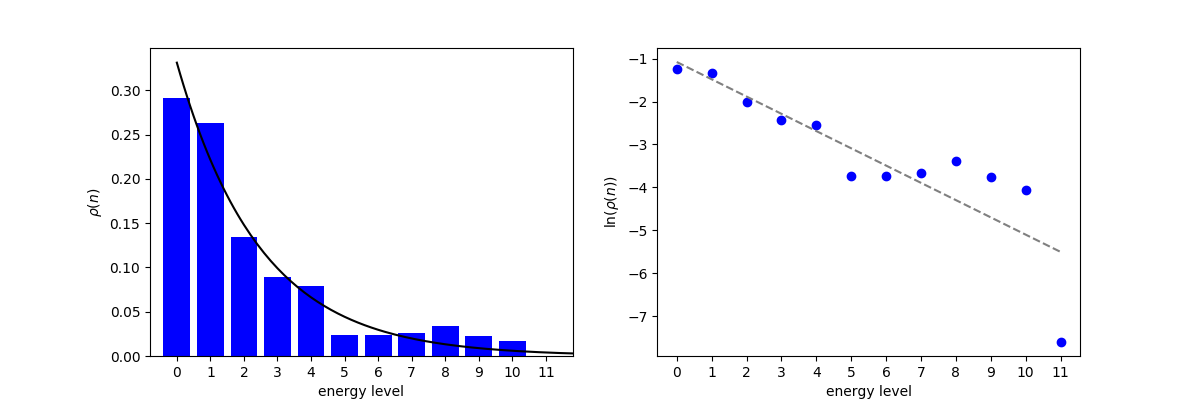

In [6]:
%matplotlib notebook
plot_prob_temp(dist_sum, nop, max_level)
plt.savefig('Boltzmann.pdf')

In [7]:
#task 6
print_w_sw(all_wbolt, all_sw, 0, 10)#start at step 0, end at step 10

step 0	 W = 12600.0	 S_w = 0.1304e-21 J/K
step 1	 W = 75600.0	 S_w = 0.1551e-21 J/K
step 2	 W = 75600.0	 S_w = 0.1551e-21 J/K
step 3	 W = 75600.0	 S_w = 0.1551e-21 J/K
step 4	 W = 50400.0	 S_w = 0.1495e-21 J/K
step 5	 W = 50400.0	 S_w = 0.1495e-21 J/K
step 6	 W = 75600.0	 S_w = 0.1551e-21 J/K
step 7	 W = 151200.0	 S_w = 0.1647e-21 J/K
step 8	 W = 151200.0	 S_w = 0.1647e-21 J/K
step 9	 W = 302400.0	 S_w = 0.1742e-21 J/K


<IPython.core.display.Javascript object>


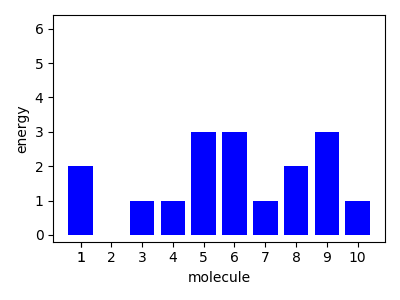

Statistical weight: 4200    Boltzmann entropy: 0.1152e-21 J/K


In [6]:
#task 7
nop = 10
en = 2

get_w_sw(nop, en)